# Import statements

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import datetime

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

plt.rcParams["text.usetex"] = True
plt.rcParams['figure.dpi'] = 600


In [2]:
auto_tag = datetime.datetime.today().strftime("%Y%m%d")[2:]  # YYMMDD
def savefig(name, save_tag=auto_tag, save=False):
    filename = f"{name}_{save_tag}.png"
    plt.savefig(f"export/{filename}", dpi=300)
    print(f"Saved {filename}")

# 1 Error assessment

In [3]:
def import_points(filepath):
    file = pd.read_csv(filepath, skiprows=1, names=["x", "y", "z", "m3c2", "r", "g", "b", "nx", "ny", "nz"])
    file = file[np.abs(file["m3c2"] - file["m3c2"].mean()) <= (3 * file["m3c2"].std())]
    
    return file

years = [1997, 2004, 2014, 2017]
files = [import_points(f"input/errors/{name} Peri.txt") for name in ["Syd97", "Syd04", "Syd14"]]


files[0].head()

,x,y,z,m3c2,r,g,b,nx,ny,nz
0,47473.063,35890.137,2053.672,-0.167,84,68,59,0.046542,-0.063860,0.996873
1,47467.801,35893.863,2053.564,-0.226,73,58,47,-0.102179,-0.029665,0.994324
2,47475.223,35888.848,2053.837,-0.246,79,62,49,0.108021,-0.016367,0.994014
3,47471.531,35892.660,2053.495,-0.139,77,59,46,-0.120473,-0.039407,0.991934
4,47475.027,35889.410,2053.871,-0.247,84,66,52,-0.020780,0.106085,0.994140


## 1.1 Error measures

In [4]:
columns = ["mean", "std", "mae"]
errors = pd.DataFrame(columns=columns)

years = [1997, 2004, 2014, 2017]
for year, file in enumerate(files):
    mean = file["m3c2"].mean()
    std = file["m3c2"].std()
    mae = file["m3c2"].abs().mean()
    
    errors.loc[years[year], columns] = mean, std, mae

def rounded(decimal=2):
    return errors.applymap(lambda x: round(x, decimal))

rounded()

,mean,std,mae
1997,0.18,0.70,0.59
2004,0.32,0.85,0.68
2014,-0.22,0.40,0.28


## 1.2 Error histograms

Saved errors_180524.png


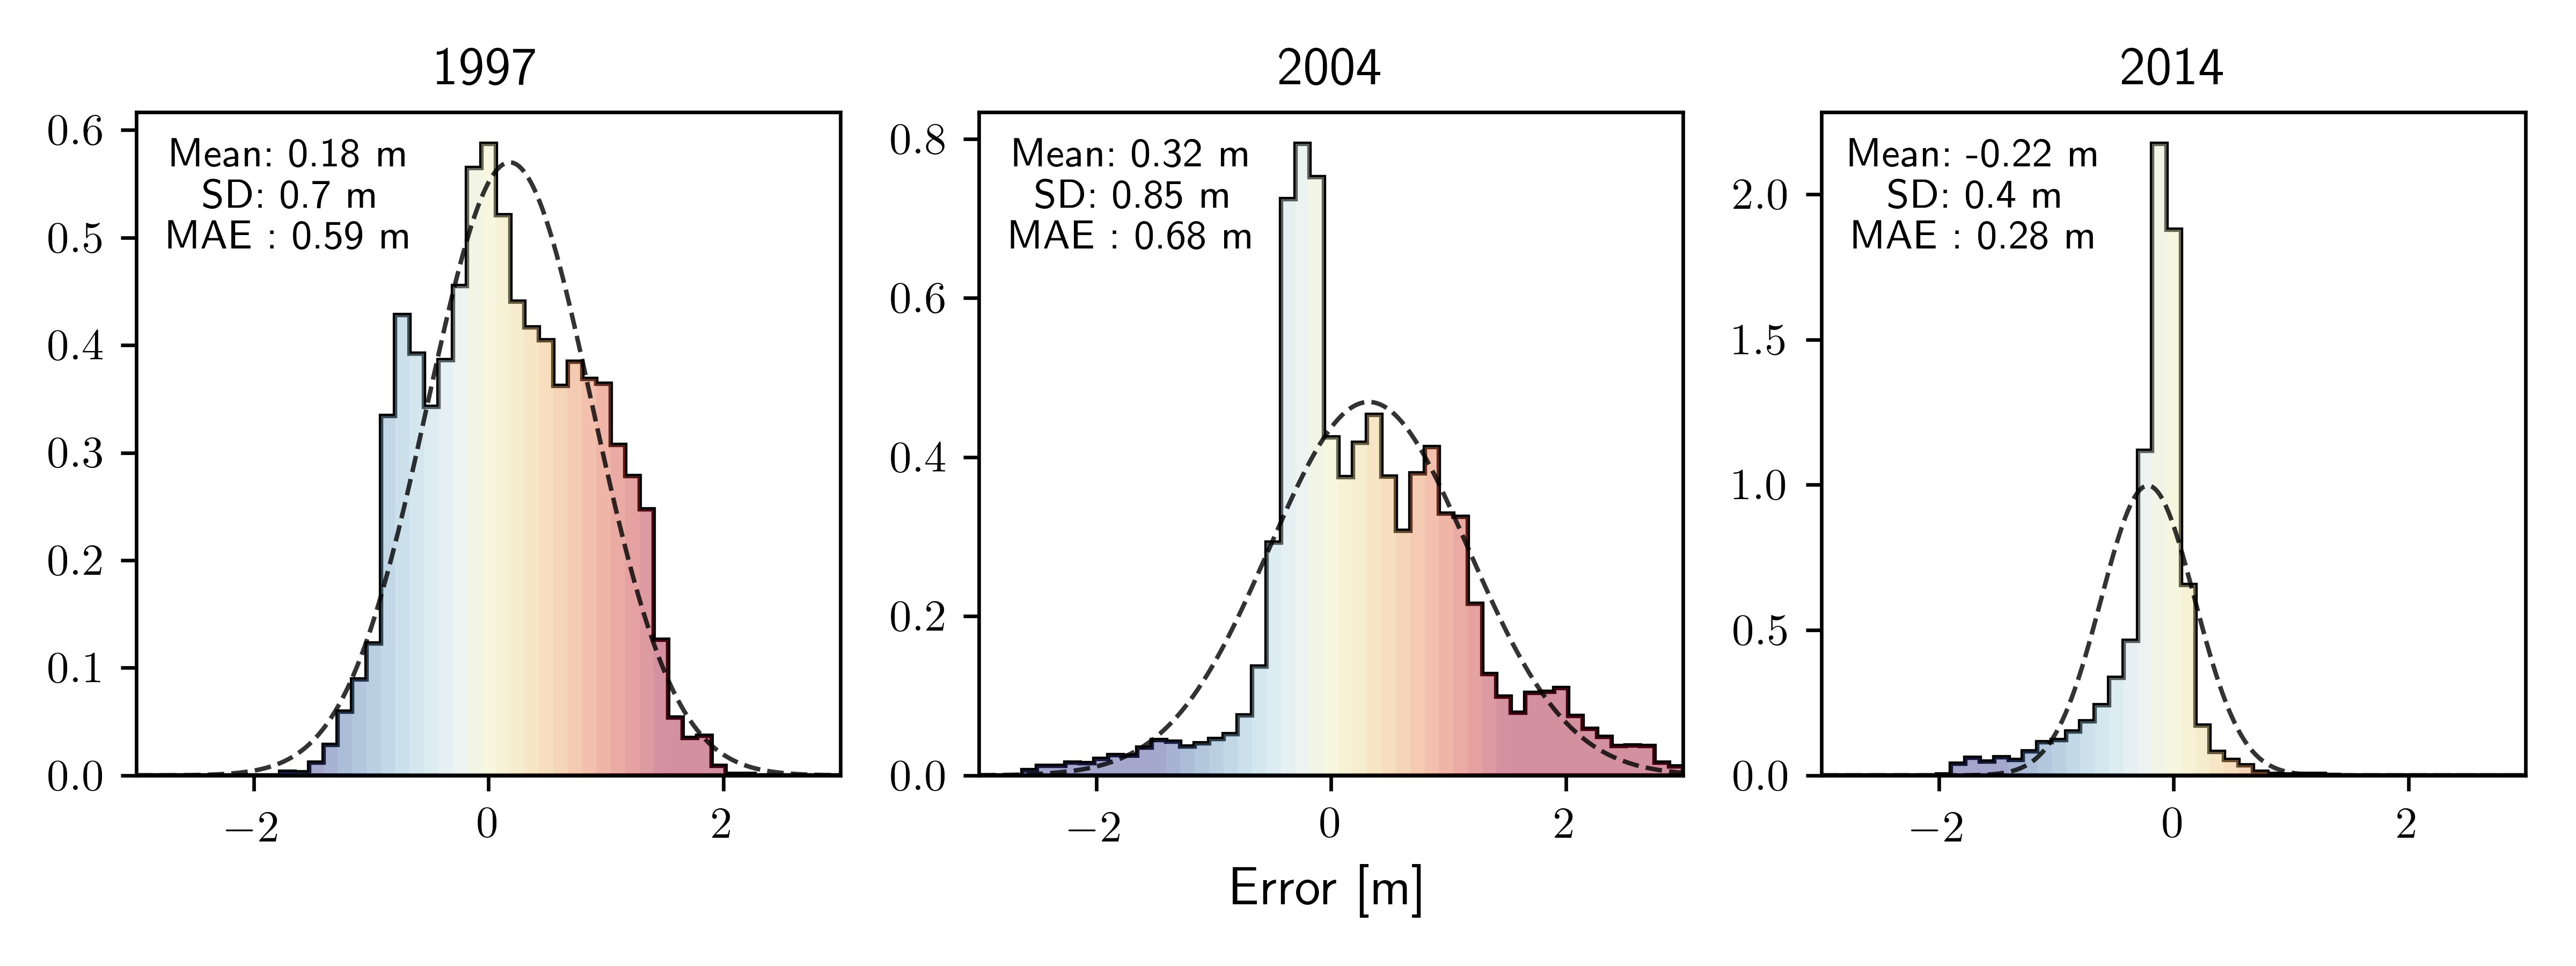

In [37]:
plt.figure(figsize=(8, 3))

for i, v in enumerate(files):
    ax = plt.subplot(1, 3, i + 1)

    # Histogram
    cm = plt.cm.get_cmap("RdYlBu_r")  # Colormap
    
    x_min = -3
    x_max = 3
    n_bins = np.linspace(-3, 3, 50)  # Number of bins between interval
    plt.xlim((-3, 3))
    
    
    plt.hist(v["m3c2"], edgecolor="black", bins=n_bins, density=True, color=(0.95,) * 3, histtype="stepfilled")
    n, bins, patches = plt.hist(v["m3c2"], bins=n_bins, density=True)

    # Calculate bins to fill with color
    bin_centers = 0.5 * (bins[:-1] + bins[1:])    
    col = bin_centers / 3 + 0.5
    
    # Fill bins
    for c, p in zip(col, patches):  
        plt.setp(p, "facecolor", cm(c)[:-1] + (0.4,))
        
    mean, std, mae = rounded().loc[years[i]]  # Error measures
    
    # Gaussian distribution from mean and std
    x_axis = np.arange(-10, 10, 0.0001)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), linestyle="--", c="k", lw=1, alpha=0.8)
    
    # Text and names
    stats = f"Mean:\ {round(mean, 2)} m\nSD: {round(std, 2)} m\nMAE : {round(mae, 2)} m"
    plt.text(0.22, 0.87, stats, horizontalalignment="center", verticalalignment="center", transform=ax.transAxes, fontsize=9)
    plt.title(years[i], loc="center")
    
    if i == 1:
        plt.xlabel("Error [m]", fontsize=12)
        
plt.tight_layout()
    

#savefig("errors")

# 2 Mass balance

In [6]:
heights = pd.read_csv("input/elevation_profile/sydtoppen.csv", sep=";", squeeze=True, index_col=0)
heights.head()

year
1947    2115.0
1948       NaN
1949       NaN
1950       NaN
1951    2119.0
Name: elevation, dtype: float64

In [7]:
balance = pd.read_csv("input/elevation_profile/mass_balance.csv", sep=";", index_col=0)
balance = balance.applymap(lambda x: float(x.replace(",", ".")))

balance.head()

,nb,cumul
year,,
1946,-3.729,-51.269
1947,-6.831,-58.100
1948,0.000,-58.100
1949,3.003,-55.097
1950,-4.257,-59.354


Saved mass_balance_180524.png


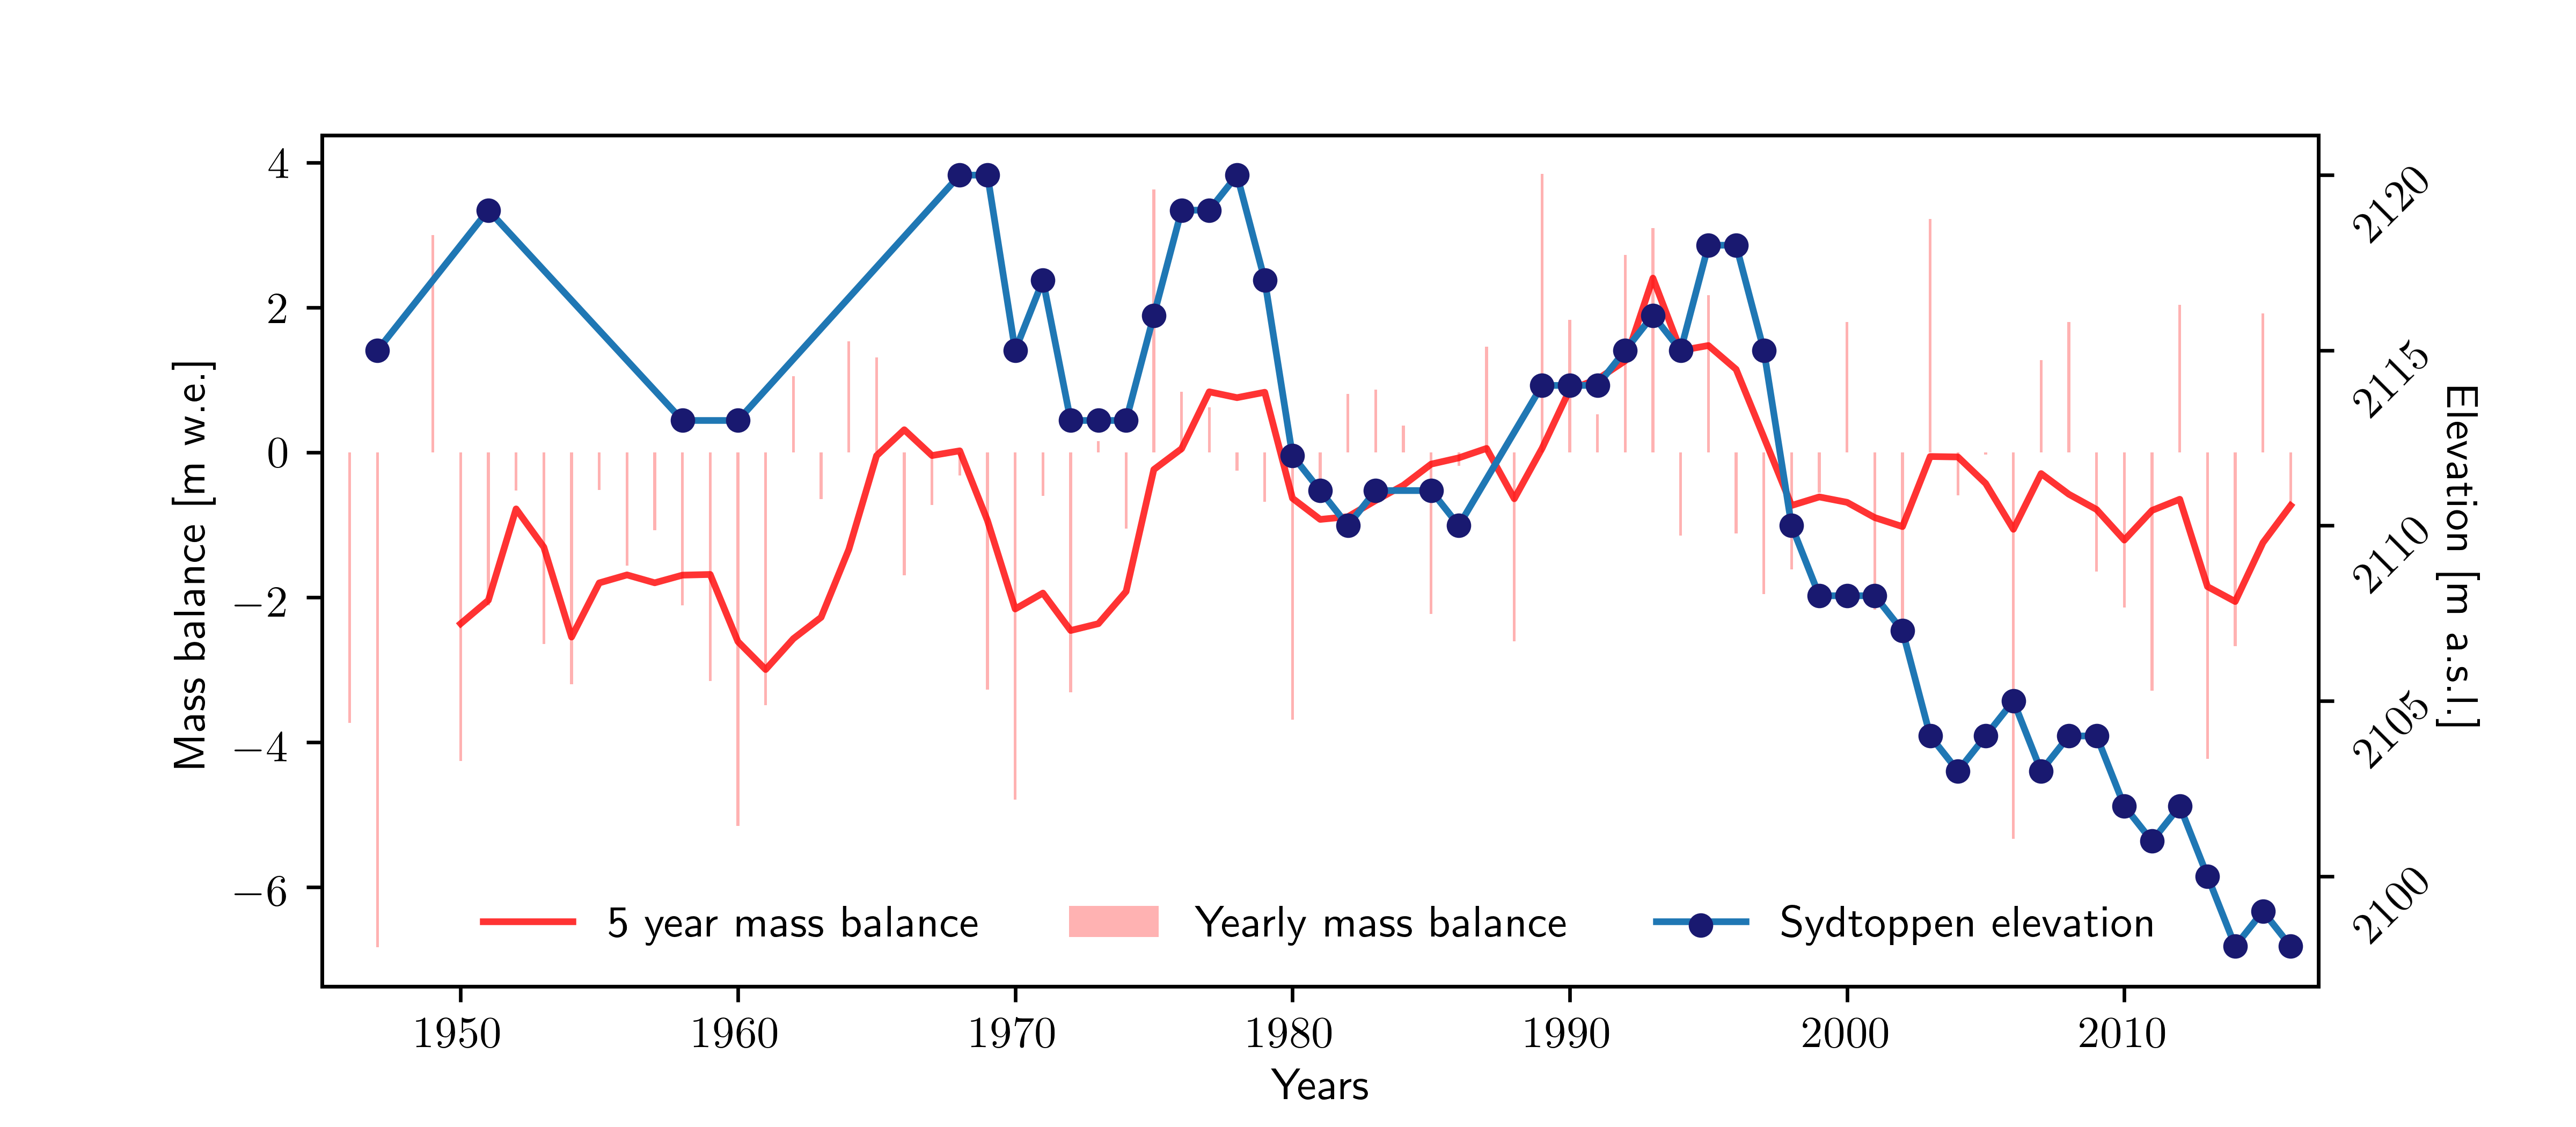

In [42]:
plt.figure(figsize=(8, 3.5))


# Full line 
averaged = balance["nb"].rolling(5).mean()
five = plt.plot(averaged, c="red", alpha=0.8, linestyle="-", zorder=4)[0]

#plt.scatter(balance.index, balance["nb"], s=3, c="r", alpha=0.3)
yearly = plt.bar(balance.index, balance["nb"], width=0.1, color="r", alpha=0.3, zorder=1)[0]

plt.ylabel("Mass balance [m w.e.]")

# Mass balance plotting
plt.gca().twinx()

# Elevation plotting
syd_pl = plt.plot(heights.dropna(), zorder=2)[0]
syd_sc = plt.scatter(heights.index, heights, s=20, c="midnightblue", zorder=3)

plt.yticks(rotation=45)
#plt.ylabel("Elevation [m a.s.l.]", rotation=-90)
plt.text(1.07, 0.5, "Elevation [m a.s.l.]", transform=plt.gca().transAxes, rotation=-90, ha="center", va="center")

labels = ["5 year mass balance", "Yearly mass balance", "Sydtoppen elevation"]
patches = ((five, ), (yearly, ), (syd_pl, syd_sc))

plt.legend(patches, labels, loc="lower center", ncol=3, frameon=False)
plt.xlim((1945, 2017))
plt.text(0.5, -0.12, "Years", transform=plt.gca().transAxes, ha="center", va="center")

plt.subplots_adjust(right=0.90)

#savefig("mass_balance")

# Peak variation

Saved peak_position_180524.png


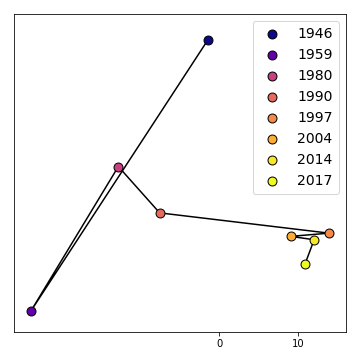

In [9]:
pos = pd.read_csv("input/syd_properties/peak_positions.csv", index_col=0, parse_dates=False)

pos[["easting", "northing"]] = pos[["easting", "northing"]].apply(lambda x: x - x.mean())

cm = plt.cm.get_cmap("plasma")  # Colormap


pos["color"] = [cm((year - pos.index.min()) / (pos.index.max() - pos.index.min())) for year in pos.index]

plt.figure(figsize=(5, 5))

plt.plot(pos.easting, pos.northing, c="k", zorder=1, label="__none__")
for year, row in pos.iterrows():
    plt.scatter(row.easting, row.northing, c=row.color, edgecolors="k", label=year, zorder=2, s=80)

plt.legend(fontsize=14)
plt.axis((-26, 16, -15, 25))
plt.xticks([0, 10])
plt.yticks([])


plt.tight_layout()

#savefig("peak_position")